# Double Q-Learning, Duelling Q-Learning, Learning from images
---
In this notebook, you will implement a DQN agent with OpenAI Gym's [Pong](https://www.gymlibrary.dev/environments/atari/pong/) environment.

Comparing to the previous notebooks, the following enhancments/changes are introduced.
- Agent is learning from images (pixels), not from vector-based states. Thus, a Convolutional Neural Network is used.
- Double DQN algorithm is used
- Duelling Neural Network is used.

<a target="_blank" href="https://colab.research.google.com/github/PrzemekSekula/ReinforcementLearningClasses/blob/master/DQLearning/02_CNN_DuelingQN.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>

### Double Deep Q-Learning explained 
---
In the previous notebook we were using additional neural network `target neural network` to estimate $TD_{target}$ according to the formula: 
$$TD_{target} = R + \gamma \max\limits_{a'} Q(S_{t+1}, \argmax\limits_{a'}Q(S_{t+1}, a', w^-), w^-)$$ 
In other words, we were using target neural network to select the best action $a'$, and then we were using the same network to estimate the value of this action. Such an approach can be prone to overestimation. 
To solve this problem, we may select the best action using other set of weights, and then estimate the value of this action with target neural network. In fact, we already have additonal set of weights $w$ that comes from the `local neural network`, so our $TD_{target}$ estimations can be performed as follows:
$$TD_{target} = R + \gamma \max\limits_{a'} Q(S_{t+1}, \argmax\limits_{a'}Q(S_{t+1}, a', w^-), w)$$

### Dueling Deep Q-Network Explained
---

Dueling Q network architecture was proposed in the [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581) paper. The general idea is to calculate state action values using state values $V(s)$ and advantages $A(s, a) = Q(s, a) - V(s)$. It is being done by bulding a network architecture with parallel layers for calculating $V(s)$ and  $A(s, a)$ as presented in the image (image from the abovementioned paper).

<img src="https://raw.githubusercontent.com/PrzemekSekula/ReinforcementLearningClasses/main/img/DuelingQNetwork.jpg" alt="Dueling Q Network" style="width: 640px;">

The only issue is how to ensure that $V(s)$ will produce a reasonable estimate for state values. We are doing it, by assuming, that the mean advantage value should always be 0. Thus the final formula:

$$Q(s, a) = V(s) + A(s, a) - \frac{1}{|A|}\sum\limits_{a'}A(s, a')$$

This is all implemented in `DuelingQNetwork` class.

There is one more improvement - to keep it consistent with the paper I clipped the gradients to 10 in order to avoid gradient exploding problem.


### TO DO
---

Your task is to complete the code in this notebook. The places were you should create your own implementation are described in this notebook and marked with `# ENTER YOUR CODE HERE` comments.

*Note: This code uses replay buffer implemented in the `reply_buffer.py` file. This implementation comes from [OpenAI baselines GitHub repository](https://github.com/openai/baselines/tree/master/baselines/deepq).*



In [12]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --upgrade gym
    !pip install --upgrade gym[atari]
    !pip install --upgrade gym[accept-rom-license]

    !wget https://raw.githubusercontent.com/PrzemekSekula/ReinforcementLearningClasses/main/DQLearning/replay_buffer.py
    !wget https://raw.githubusercontent.com/PrzemekSekula/ReinforcementLearningClasses/main/DQLearning/segment_tree.py
    !wget https://raw.githubusercontent.com/PrzemekSekula/ReinforcementLearningClasses/main/DQLearning/Notebook02_steps150.pth


In [13]:
# Import packages
import gym
import torch
import numpy as np
import random
from collections import deque

import matplotlib.pyplot as plt
from skimage.transform import resize

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Device:', device)

Device: cpu


In [15]:
env = gym.make('PongDeterministic-v4')
state = env.reset()
print('State shape:', state.shape)
print('Valid actions:', env.unwrapped.get_action_meanings())

NameNotFound: Environment PongDeterministic doesn't exist. 

### Actions
This environment has six actions. To simplify things, we are going to use only three of them:
- `FIRE` (1) - do not move
- `RIGHTFIRE` (4) - move right
- `LEFTFIRE` (5) - move left

Pressing `FIRE` is important only in the beginning - it starts a game. In any other situation there is no difference between `NOOP` and `FIRE`, `RIGHT` and `RIGHTFIRE` etc. By adding fire to every action we force the agent to start a game, when it is necessary.

With three actions our neural network should have three output neurons. The only problem is with numbering actions. From the neural network perspective, the most natural numeration is 0, 1, and 2. This way we can use `argmax` or `index` to select particular action. Environment uses 1, 4, and 5, so we need a function that maps NN-related action numbers to Environment-related action numbers. We called this function `preprocess_action`.

In [ ]:
# Hyperparameters

STATE_SIZE = (2, 48, 48) # 2 frames of 48x48 pixels (gray scale)
ACTION_SIZE = 3 # 3 possible actions: 0 (FIRE), 1 (RIGHTFIRE), 2 (LEFTFIRE)

In [ ]:
def preprocess_action(action):
    """Changes the action from a neural network into the real action.
    We are using it, because we want to use only three actions:
    FIRE (1), RIGHTFIRE (4), and LEFTFIRE (5).
    Args:
        action (int): number of neuron (0 , 1 or 2)

    Returns:
        int: number of action (4 or 5)
    """
    if action == 0: 
        return 1 # FIRE
    elif action == 1:
        return 4 # RIGHTFIRE
    elif action == 2:
        return 5 # LEFTFIRE
    else:
        raise ValueError('Action must be 0, 1 or 2')  


### Image preprocessing
To simplify things the image is preprocessed
- The upper and lower (irrelevant) parts are cropped
- Image is changed into grayscale (we use only last channel)
- Image is resized (by default to 48x48)

The original and preprocessed images are visualized in the cell below.

Text(0.5, 1.0, 'Preprocessed image')

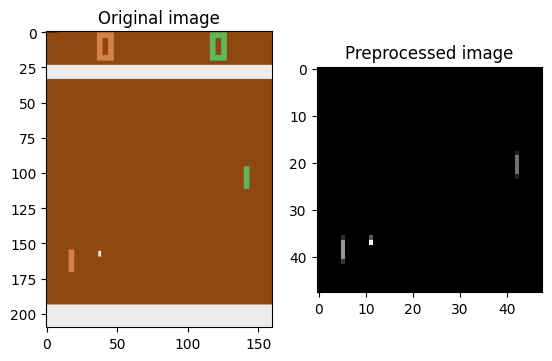

In [ ]:
def image_preprocess(image, output_size = STATE_SIZE[1:]):
    """
    Image preprocessing function.
    - Crops the image and leaves only the playing area
    - Changes the RGB image to gray scale
    - resizes the image to the output_size

    Args:
        image (np.array): input image
        output_size ((int, int)): Size of the output image. Defaults to STATE_SIZE[1:].

    Returns:
        _type_: _description_
    """
    img = np.mean(image[34:-16:2,::2], axis=-1)/255.
    
    return resize(img, output_size, anti_aliasing=True)

# Test the image_preprocess function
state, _ = env.reset()
for _ in range(25):
    state, _, _, _, _ = env.step(0)
ax = plt.subplot(121)
plt.imshow(state)
plt.title('Original image')
plt.subplot(122)
plt.imshow(image_preprocess(state), cmap='gray')
plt.title('Preprocessed image')

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import imageio

def create_video(agent, video_path, 
                 nr_frames = STATE_SIZE[0],
                 render = False):
    env = gym.make('PongDeterministic-v4', render_mode = 'rgb_array')

    obs, _ = env.reset()
    if render:
        img_list = [env.render()]
    else:
        img_list = [obs]
    
    state_buffer = deque(maxlen=nr_frames)
    img = image_preprocess(obs)
    while len(state_buffer) < nr_frames:
        state_buffer.append(img)

    state = np.asarray(state_buffer)

    score = 0
    for t in range(10000):
        # TO DO: select an action
        action = agent.act(state, 0)
        next_obs, reward, done, _, _ = env.step(preprocess_action(action))
        
        if render:
            img_list.append(env.render())
        else:
            img_list.append(next_obs)
            
        state_buffer.append(image_preprocess(next_obs))
        state = np.asarray(state_buffer)

        if done:
            break 
    env.close()

    # Create a video file using imageio
    imageio.mimsave(video_path, img_list, fps=30)

    print (f'Visualization done. Episode ended after {t} steps.')
    
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url    
    

### Task 1 - Implement a Dueling Neural Network
Implement the neural network (`QNetwork` class):
1) In `__init__()` Create a neural network
2) In `forward()` implement the forward pass 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DuelingCNN(nn.Module):
    """Neural network that estimates Q values."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Args:
            state_size (int, int, int): Size of the state (nr_chanels, x, y).
            action_size (int): Dimension of each action. It equals 
                the number of the network outputs

        """
        super(DuelingCNN, self).__init__()
        
        nr_chanels, x, y = state_size
        
        # TODO: Create convolutional layers as follows:
        #     Conv2d: 16 3x3 filters, padding='same', activation=ReLU)
        #     MaxPool2d: 2x2 kernel
        #     Conv2d: 32 3x3 filters, padding='same', activation=ReLU)
        #     MaxPool2d: 2x2 kernel
        # Note - if you use nn.Sequential, you just separate the layers by commas
        
        self.conv_layers = nn.Sequential(
            # ENTER YOUR CODE HERE
            nn.Conv2d(nr_chanels, 16, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(16, 32, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        
        # Pass an input tensor through the convolutional block
        # to calculate the number of neurons in the flatten layer
        input_tensor = torch.randn(1, nr_chanels, x, y)
        output = self.conv_layers(input_tensor)
        self.nr_flatten = np.prod(output.size()[1:])

        # TODO: Create value and advantage layers as follows:
        #     Flatten
        #     Dense: 128 units, activation=ReLU
        #     Dense: 1 unit (value)

        self.value_block = nn.Sequential(
            # ENTER YOUR CODE HERE
            nn.Linear(self.nr_flatten, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # TODO: Create value and advantage layers as follows:
        #     Flatten
        #     Dense: 128 units, activation=ReLU
        #     Dense: asction_size units (advantage)
        
        self.advantage_block = nn.Sequential(
            # ENTER YOUR CODE HERE
            nn.Linear(self.nr_flatten, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        
        
    def forward(self, state):
        """Build a network that maps state -> action values.
        Args:
            state (torch.Tensor): The state of the environment
        Returns:
            torch.Tensor: The action values
        """
        
        # TODO: Calculate features from conv_layers
        features = self.conv_layers(state) # ENTER YOUR CODE HERE
        
        # Flatten the features
        features = features.view(features.size(0), -1)

        # TODO: Calculate advantage and value from features
        value = self.value_block(features) # ENTER YOUR CODE HERE
        advantage = self.advantage_block(features) # ENTER YOUR CODE HERE
        
        # TODO: Understand the following line
        q = value + advantage - advantage.mean(dim=-1, keepdim=True)
        return q


### Task 2 - Implement the Agent:
Implement the `Agent` class.
1) In `__init__()` create a neural network, optimizer and Replay Buffer
2) In `step()` add the experience to the memory buffer
3) In `learn()` calculate `next_actions`, `Q_targets`, and `loss`

In [ ]:
from replay_buffer import ReplayBuffer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size,
                 buffer_size = int(1e4),
                 batch_size = 64,
                 gamma = 0.99,
                 lr = 5e-4,
                 update_every = 4,
                 device = None,
                 load_from = None):
        """Initialize an Agent object.
        Args:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            buffer_size (int): replay buffer size. Default: int(1e5)
            batch_size (int): minibatch size. Default: 64
            gamma (float): discount factor. Default: 0.99
            lr (float): learning rate. Default: 5e-4
            update_every (int): how often to update the network. Default: 1        
            device (torch.device): device to use. Default: None    
            load_from (str): path to the checkpoint file to load. Default: None
        """
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.device = device

        # Q-Network
        # TODO: Create local and target networks
        # Remember about .to(device)
        self.local_network = DuelingCNN(state_size, action_size).to(device) # ENTER YOUR CODE HERE
        self.target_network = DuelingCNN(state_size, action_size).to(device) # ENTER YOUR CODE HERE
        self.target_hard_update()       
        
        # TODO: Create the optimizer (Adam with learning rate lr)
        self.optimizer = optim.Adam(self.local_network.parameters(), lr) # ENTER YOUR CODE HERE

        # TODO: Create a Replay Buffer. Use ReplayBuffer class from the 
        # reply_buffer.py file. Use buffer_size as the buffer size
        self.memory = ReplayBuffer(buffer_size) # ENTER YOUR CODE HERE
        
        # Initialize time step (for updating every self.update_every steps)
        self.t_step = 0
        
        if load_from is not None:
            self.load(load_from)
            
    
    def step(self, state, action, reward, next_state, done):
        
        # TODO: Save experience in replay buffer. Use self.memory.add()
        # ENTER YOUR CODE HERE
        
        self.memory.add(state, action, reward, next_state, done)

        # Learn every self.update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample(self.batch_size)
                self.learn(experiences)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_network.eval()
        with torch.no_grad():
            action_values = self.local_network(state)
        self.local_network.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            action =  np.argmax(action_values.cpu().data.numpy())
        else:
            action = random.choice(np.arange(self.action_size))
        return action
        #return preprocess_action(action)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        device = self.device  # for shortening the following lines
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions.reshape(-1, 1)).to(device)
        rewards = torch.FloatTensor(rewards.reshape(-1, 1)).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones.reshape(-1, 1)).to(device)        
        
        
        
        
        with torch.no_grad():
            # TODO: Calculate next actions using local network
            # Hint1: You can use argmax(1)
            # Hint2: Remember to use detach() to avoid backpropagation
            # Hint3: You need to keep the dimentions (use keepdim)
            next_actions = self.local_network(next_states).argmax(dim=1, keepdim=True).detach() # ENTER YOUR CODE HERE
            
            # Get max predicted Q values (for next states) from target model
            Q_next = self.target_network(next_states).gather(1, next_actions)
            
            # TODO: Compute TD targets
            TD_target = rewards + (self.gamma * Q_next * (1 - dones)) # ENTER YOUR CODE HERE

        # Get expected Q values 
        Q_curr = self.local_network(states).gather(1, actions)

        # TODO: Compute loss. Use F.mse_loss
        loss = F.mse_loss(Q_curr, TD_target) # ENTER YOUR CODE HERE
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def target_hard_update(self):
        """ Assigns Local network weights to target network weights
        """
        self.target_network.load_state_dict(self.local_network.state_dict())
        self.target_network.eval()        

        
    def save(self, path = 'checkpoint.pth'):
        """Saves the network
        Args:
            path (str): path to save the network. Default is 'checkpoint.pth'
        """
        torch.save(self.local_network.state_dict(), path)
 
    def load(self, path = 'checkpoint.pth'):
        """Loads the network
        Args:
            path (str): path with the weights. Default is 'checkpoint.pth'
        """
        self.local_network.load_state_dict(torch.load(path))
        self.target_hard_update()

### Pretrained agent
Training an agent from scratch is doable, but time-consuming. On Google Colab (with GPU) it usually takes 1-2 hours. As an alternative you may use a pretrained agent - an agent trained for 300 episodes. This agent is still far from being perfect, yet it already knows basics, which speeds up the training process.

To use the pretrained agent set `LOAD_PRETRAINED = True`. 


In [ ]:
#zmienić load_pretrained na true żeby skrócić czas trenowania
LOAD_PRETRAINED = True
video_url = None

agent = Agent(
    state_size=STATE_SIZE, 
    action_size = ACTION_SIZE,
    device=device)

if LOAD_PRETRAINED:
    agent.load('Notebook02_steps150.pth')
    create_video(agent, 'output.mp4')
    video_url = create_video(agent, 'output.mp4')

HTML(video_url)

Visualization done. Episode ended after 3152 steps.


Visualization done. Episode ended after 3152 steps.


### Task 3. Train the Agent
Complete the `train_agent()` function.
1) Select and perform an action
2) Use `agent.step()` to update the agent's knowledge
3) Decay the explorarion rate epsilon


In [ ]:
def train_agent(
        n_episodes = 10000,        # Maximum number of episodes
        max_t = 10000,             # Maximum number of timesteps per episode
        eps_start = 1.0,           # Starting value of epsilon
        eps_end = 0.01,            # Minimum value of epsilon
        eps_decay = 0.99,          # Decay rate of epsilon
        expected_reward = 18,      # Expected average reward to solve the environment
        update_target_every = 1,   # Update the target network every x steps        
        nr_frames = STATE_SIZE[0], # Number of frames to stack
        ):
    """Deep Q-Learning.
    Args: 
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for 
            epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay factor (per episode) 
            for decreasing epsilon
        expected_reward (float): finish when the average score
            is greater than this value
        upate_target_every (int): how often should the target 
            network be updated. Default: 1 (per every episode)  
        nr_frames (int): number of frames to stack           
    Returns:
        scores (list): list of scores from each episode        
    """
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    
    state_buffer = deque(maxlen=nr_frames)
    
    step_nr = 0

    if LOAD_PRETRAINED:
        episode_start = 150
        eps = max(eps_end, eps * eps_decay ** (episode_start-1))
    else:
        episode_start = 1
        
    for episode in range(episode_start, n_episodes+1):
        obs, info = env.reset()
        
        img = image_preprocess(obs)
        while len(state_buffer) < nr_frames:
            state_buffer.append(img)

        state = np.asarray(state_buffer)
        
        score = 0
        for t in range(max_t):
            # TO DO: select an action
            action = None # ENTER YOUR CODE HERE
            
            # Note that we are preprocessing the action to make it compatible with the environment
            next_obs, reward, done, truncated, info = env.step(preprocess_action(action))
            
            state_buffer.append(image_preprocess(next_obs))
            next_state = np.asarray(state_buffer)
            
            # TO DO: use agent.step() to update the agent
            # ENTER YOUR CODE HERE
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)
        
        # TO DO: Decay epsilon by multiplying it by eps_decay             
        # ENTER YOUR CODE HERE 
        
        step_nr = (step_nr + 1) % update_target_every
        if episode % update_target_every == 0:
            agent.target_hard_update()     
        
        mean_score = np.mean(scores_window)
        
        print(f'\rEpisode {episode}, \tsteps: {t}, \tAverage Score: {mean_score:.2f}     ', end="")
        
        if episode % 100 == 0:
            print(f'\rEpisode {episode}, \tsteps: {t}, \tAverage Score: {mean_score:.2f}')
            agent.save(f'checkpoint{str(episode).zfill(4)}.pth')
        if mean_score >= expected_reward:
            print(f'\nDone in {episode:d} episodes!\tAverage Score: {mean_score:.2f}')
            agent.save(f'checkpoint{str(episode).zfill(4)}.pth')
            break
    return scores

### Train the agent


In [ ]:
from time import time
t_start = time()
scores = train_agent()
t_end = time()
print(f'Training done in {t_end - t_start:.1f} seconds')
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #') 
plt.show()

### Visualize the agent's performance

In [1]:
create_video(agent, 'output.mp4')
video_url = create_video(agent, 'output.mp4')

HTML(video_url)

NameError: name 'create_video' is not defined